# ДЗ:

1. Использовать датасет `telecom_churn.csv`
2. Обучить LogisticRegression. Использовать в качестве `baseline`.
3. Обучить на этом датасете все три вида ансамблей, использованных в этом ноутбуке. Сравнить с baseline
4. Использовать PCA для понижения размерности, или использовать статистическим методом отбор признаков SelectKBest. Затем обучить LogisticRegression в качестве `baseline`, и обучить все три вида ансамблей, рассмотренных в этом ноутбуке.
5. Сравнить результаты между собой до понижения размерности или отбора признаков, так и после них.


In [118]:
!pip3 install catboost

In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split # разбиение данных на тренировочные и тестовые

from sklearn.compose import ColumnTransformer # преобразование столбцов
from sklearn.preprocessing import OneHotEncoder # кодирование категориальных переменных
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler # нормализация и масштабирование данных

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.model_selection import cross_val_score # кроссвалидация
from sklearn.model_selection import GridSearchCV # подбор гиперпараметров с кроссвалидацией


from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import gc

sns.set()
%matplotlib inline

import sys
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 20 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column', 100) # None)
plt.style.use('seaborn-whitegrid')


# plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings('ignore')

In [120]:
df = pd.read_csv('./telecom_churn.csv')
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [122]:
df.Churn.value_counts()

False    2850
True      483
Name: Churn, dtype: int64

In [123]:
labelencoder = LabelEncoder()
d = {'Yes': 1, 'No': 0}
df["International plan"] = df["International plan"].map(d)
df["Voice mail plan"] = df["Voice mail plan"].map(d)
df['Churn'] = df['Churn'].astype(int)
df['State'] = labelencoder.fit_transform(df['State'])

In [124]:
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3,192,415,0,1,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,0
3329,49,68,415,0,0,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,0
3330,39,28,510,0,0,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,0
3331,6,184,510,1,0,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0


In [125]:
X = df.drop('Churn', axis=1)  # Признаки
y = df['Churn']  # Целевая переменная

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_accuracy


0.8470764617691154

In [128]:
def print_results(classifier):
  y_pred = classifier.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
  disp.plot()
  plt.show()

  print(f"Score: {classifier.score(X_test, y_test)}")

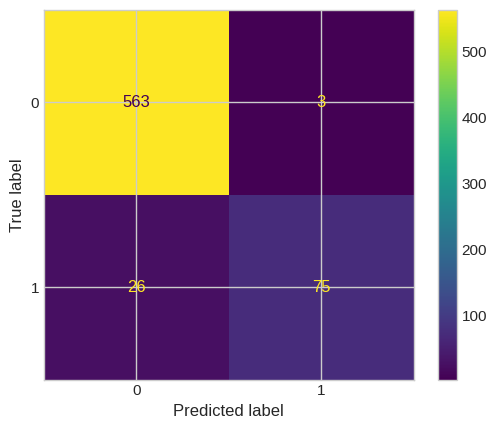

Score: 0.9565217391304348


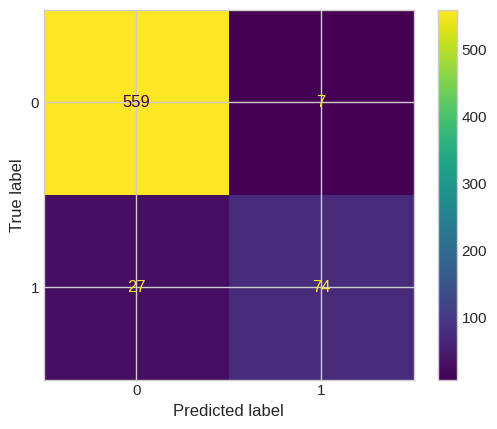

Score: 0.9490254872563718


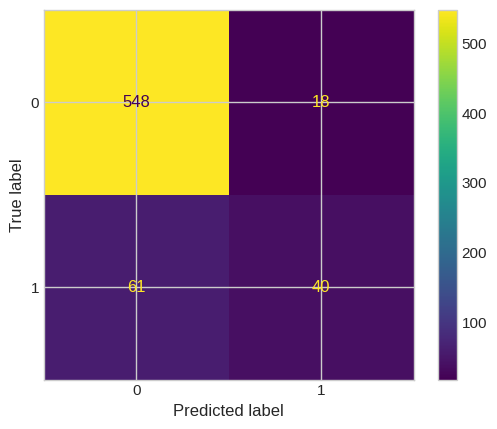

Score: 0.881559220389805


In [129]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print_results(rf_model)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print_results(gb_model)

ab_model = AdaBoostClassifier()
ab_model.fit(X_train, y_train)
ab_predictions = ab_model.predict(X_test)
ab_accuracy = accuracy_score(y_test, ab_predictions)
print_results(ab_model)

In [140]:
k_best = SelectKBest(score_func=chi2, k=10)
X_train_new = k_best.fit_transform(X_train, y_train)
X_test_new = k_best.transform(X_test)

In [142]:
lr_new = LogisticRegression()
lr_new.fit(X_train_new, y_train)
lr_new_pred = lr_new.predict(X_test_new)
baseline_accuracy_new = accuracy_score(y_test, lr_new_pred)
baseline_accuracy_new

0.865

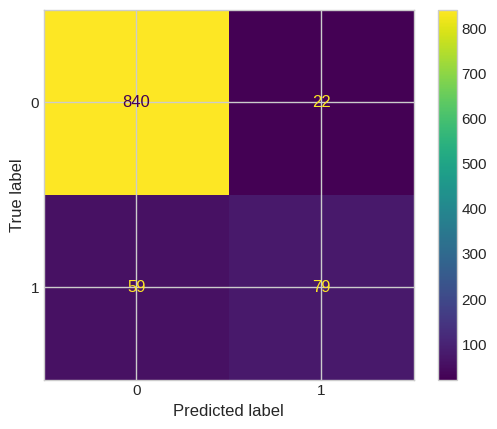

Score: 0.919


In [143]:
rfc_new = RandomForestClassifier()
rfc_new.fit(X_train_new, y_train)
rfc_new_pred = rfc_new.predict(X_test_new)
rfc_accuracy_new = accuracy_score(y_test, rfc_new_pred)
print_results(rfc_new)

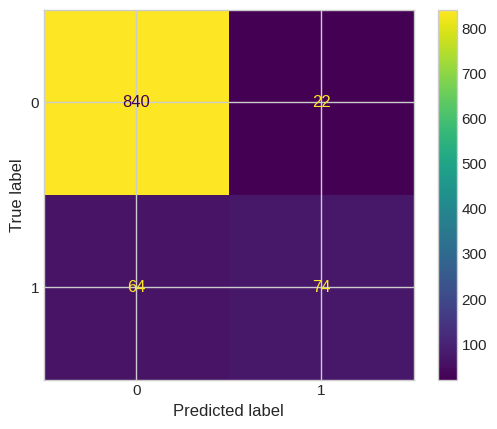

Score: 0.914


In [144]:
gbc_new = GradientBoostingClassifier()
gbc_new.fit(X_train_new, y_train)
gbc_new_pred = gbc_new.predict(X_test_new)
gbc_accuracy_new = accuracy_score(y_test, gbc_new_pred)
print_results(gbc_new)

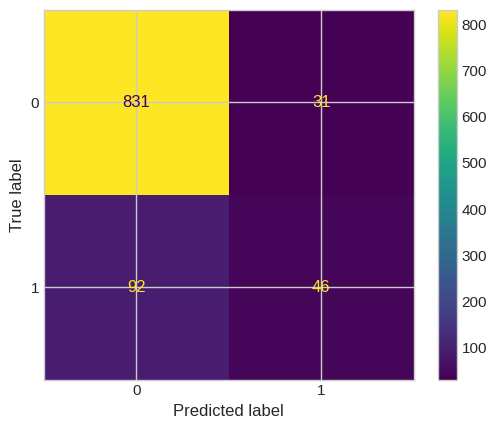

Score: 0.877


In [145]:
abc_new = AdaBoostClassifier()
abc_new.fit(X_train_new, y_train)
abc_new_pred = abc_new.predict(X_test_new)
abc_accuracy_new = accuracy_score(y_test, abc_new_pred)
print_results(abc_new)

In [147]:
print("Baseline Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Gradient Boosting Accuracy:", gb_accuracy)
print("AdaBoost Accuracy:", ab_accuracy)

print("Logistic Regression with PCA Accuracy:", baseline_accuracy_new)
print("Random Forest with PCA Accuracy:", rfc_accuracy_new)
print("Gradient Boosting with PCA Accuracy:", gbc_accuracy_new)
print("AdaBoost with PCA Accuracy:", abc_accuracy_new)

Baseline Logistic Regression Accuracy: 0.8470764617691154
Random Forest Accuracy: 0.9565217391304348
Gradient Boosting Accuracy: 0.9490254872563718
AdaBoost Accuracy: 0.881559220389805
Logistic Regression with PCA Accuracy: 0.865
Random Forest with PCA Accuracy: 0.919
Gradient Boosting with PCA Accuracy: 0.914
AdaBoost with PCA Accuracy: 0.877


По итогу отбор лучших данных только ухудшил результаты.